# V.3
- ResNet
- 이미지 상단 제목 데이터 추가

In [1]:
import pandas as pd
import numpy as np
import os
import time
import random
from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import timm
import torch
import albumentations as A
import torch.nn as nn
from albumentations.pytorch import ToTensorV2
from torch.optim import Adam
from torchvision import transforms
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import accuracy_score, f1_score

import wandb

import warnings
warnings.filterwarnings("ignore")

In [2]:
# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
device

device(type='cuda')

# CustomDataset

In [5]:
class customdataset(torch.utils.data.Dataset):
    def __init__(self, csv, path, transforms):
        super().__init__()
        self.df = pd.read_csv(csv).values
        self.path = path
        self.transforms = transforms

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        name, target = self.df[idx]
        img = np.array(Image.open(os.path.join(self.path, name)))
        img = self.transforms(img)
    
        return img, target

In [6]:
'''
class GaussianNoise:
    def __init__(self, mean, std_range):
        self.mean = mean
        self.std_range = std_range

    def __call__(self, tensor):
        std = random.uniform(*self.std_range)
        noise = torch.randn(tensor.size())*std + self.mean
        return tensor + noise
'''

class RandomPadding:
    def __init__(self, padding_range=(0, 50), fill=0):
        self.padding_range = padding_range
        self.fill = fill

    def __call__(self, image):
        # 각 방향에 대해 랜덤한 패딩 값 생성
        pad_top = random.randint(*self.padding_range)
        pad_bottom = random.randint(*self.padding_range)
        pad_left = random.randint(*self.padding_range)
        pad_right = random.randint(*self.padding_range)
        
        # 패딩 추가
        padding = (pad_left, pad_top, pad_right, pad_bottom)
        return T.functional.pad(image, padding, fill=self.fill)

'''
# 랜덤 정규화 변환 클래스
class RandomNormalize:
    def __init__(self, mean_range, std_range):
        self.mean_range = mean_range
        self.std_range = std_range

    def __call__(self, tensor):
        # 각 채널에 대한 랜덤한 mean과 std 생성
        mean = [random.uniform(*self.mean_range) for _ in range(3)]
        std = [random.uniform(*self.std_range) for _ in range(3)]
        # 정규화 적용
        tensor = T.functional.normalize(tensor, mean=mean, std=std)
        return tensor
'''

'\n# 랜덤 정규화 변환 클래스\nclass RandomNormalize:\n    def __init__(self, mean_range, std_range):\n        self.mean_range = mean_range\n        self.std_range = std_range\n\n    def __call__(self, tensor):\n        # 각 채널에 대한 랜덤한 mean과 std 생성\n        mean = [random.uniform(*self.mean_range) for _ in range(3)]\n        std = [random.uniform(*self.std_range) for _ in range(3)]\n        # 정규화 적용\n        tensor = T.functional.normalize(tensor, mean=mean, std=std)\n        return tensor\n'

In [7]:
aug_transforms = T.Compose([
    T.ToTensor(),
    T.RandomRotation(180),
    T.RandomHorizontalFlip(p=0.5),
    RandomPadding(padding_range=(10, 20), fill=50),  # 랜덤 패딩 추가
    T.RandomResizedCrop(size=(600,600), scale=(0.5, 1.0)),
])

simple_transforms = T.Compose([
    T.ToTensor(),
    T.RandomRotation(180),
    T.RandomHorizontalFlip(p=0.5),
    T.Resize((600, 600))
])

origin_transforms = T.Compose([
    T.ToTensor(),
    T.Resize((600, 600))
    ])

# augraphy 적용 + 간단한 transforms 적용
aug_dataset_1 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/Augmentation/augraphy/augmented', transforms=aug_transforms)
aug_dataset_2 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/Augmentation/augraphy/augmented2', transforms=aug_transforms)
aug_dataset_3 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/Augmentation/augraphy/augmented3', transforms=aug_transforms)
aug_dataset_4 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/Augmentation/augraphy/augmented4', transforms=aug_transforms)
aug_dataset_5 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/Augmentation/augraphy/augmented5', transforms=aug_transforms)
aug_dataset_6 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/Augmentation/augraphy/augmented6', transforms=aug_transforms)
aug_dataset_7 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/Augmentation/augraphy/augmented7', transforms=aug_transforms)
aug_dataset_8 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/Augmentation/augraphy/augmented8', transforms=aug_transforms)
aug_dataset_9 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/Augmentation/augraphy/augmented9', transforms=aug_transforms)
aug_dataset_10 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/Augmentation/augraphy/augmented10', transforms=aug_transforms) # V.3
aug_dataset_11 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/Augmentation/augraphy/augmented11', transforms=aug_transforms)
aug_dataset_12 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/Augmentation/augraphy/augmented12', transforms=aug_transforms)
aug_dataset_13 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/Augmentation/augraphy/augmented13', transforms=aug_transforms)
aug_dataset_14 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/Augmentation/augraphy/augmented14', transforms=aug_transforms)
aug_dataset_15 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/Augmentation/augraphy/augmented15', transforms=aug_transforms)
aug_dataset_16 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/Augmentation/augraphy/augmented16', transforms=aug_transforms)
aug_dataset_17 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/Augmentation/augraphy/augmented17', transforms=aug_transforms)
aug_dataset_18 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/Augmentation/augraphy/augmented18', transforms=aug_transforms)
aug_dataset_19 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/Augmentation/augraphy/augmented19', transforms=aug_transforms)
aug_dataset_20 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/Augmentation/augraphy/augmented20', transforms=aug_transforms) # V.3.2, V.3.3
aug_dataset_21 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/Augmentation/augraphy/augmented21', transforms=aug_transforms)
aug_dataset_22 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/Augmentation/augraphy/augmented22', transforms=aug_transforms)
aug_dataset_23 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/Augmentation/augraphy/augmented23', transforms=aug_transforms)
aug_dataset_24 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/Augmentation/augraphy/augmented24', transforms=aug_transforms)
aug_dataset_25 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/Augmentation/augraphy/augmented25', transforms=aug_transforms) # V.3.4


# 간단한 transforms 적용
simple_aug_dataset_1 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/train/', transforms=simple_transforms)
simple_aug_dataset_2 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/train/', transforms=simple_transforms)
simple_aug_dataset_3 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/train/', transforms=simple_transforms)
simple_aug_dataset_4 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/train/', transforms=simple_transforms) # V.3, V.3.2, V.3.3, V.3.4

# 완전 원본 데이터
origin_dataset_1 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/train/', transforms=origin_transforms) 
origin_dataset_2 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/train/', transforms=origin_transforms) # V.3.2, V.3.3, V.3.4
origin_dataset_3 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/train/', transforms=origin_transforms)  # V.3

# 추출한 제목: augraphy 적용 + 간단한 transforms 적용
title_aug_dataset_1 = customdataset('/data/ephemeral/home/data/title_df.csv', '/data/ephemeral/home/data/Augmentation/title_augraphy/augmented1', transforms=aug_transforms) # V.3.2, V.3.3, V.3.4
title_aug_dataset_2 = customdataset('/data/ephemeral/home/data/title_df.csv', '/data/ephemeral/home/data/Augmentation/title_augraphy/augmented2', transforms=aug_transforms)
title_aug_dataset_3 = customdataset('/data/ephemeral/home/data/title_df.csv', '/data/ephemeral/home/data/Augmentation/title_augraphy/augmented3', transforms=aug_transforms) # V.3

# 제목 완전 원본
title_origin_dataset_1 = customdataset('/data/ephemeral/home/data/title_df.csv', '/data/ephemeral/home/data/Augmentation/title_extracted', transforms=simple_transforms) # V.3.2, V.3.3, V.3.4
title_origin_dataset_2 = customdataset('/data/ephemeral/home/data/title_df.csv', '/data/ephemeral/home/data/Augmentation/title_extracted', transforms=simple_transforms)
title_origin_dataset_3 = customdataset('/data/ephemeral/home/data/title_df.csv', '/data/ephemeral/home/data/Augmentation/title_extracted', transforms=simple_transforms) # V.3

In [8]:
len(title_origin_dataset_1)

870

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..50.0].


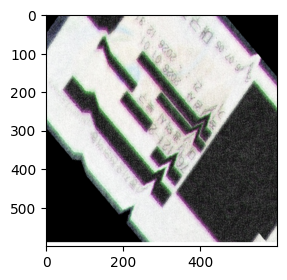

In [9]:
plt.figure(figsize=(3, 3))
plt.imshow(aug_dataset_2[10][0].permute(1, 2, 0))
plt.show()

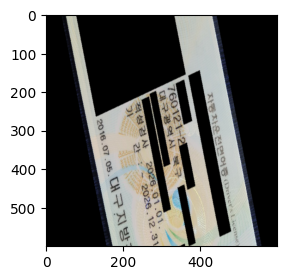

In [11]:
plt.figure(figsize=(3, 3))
plt.imshow(simple_aug_dataset_2[10][0].permute(1, 2, 0))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..50.0].


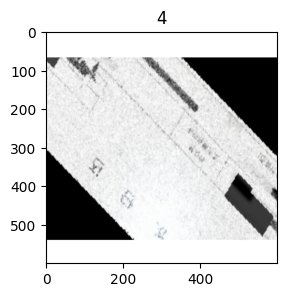

In [12]:
plt.figure(figsize=(3, 3))
plt.imshow(title_aug_dataset_3[100][0].permute(1, 2, 0))
plt.title(title_origin_dataset_3[100][1])
plt.show()

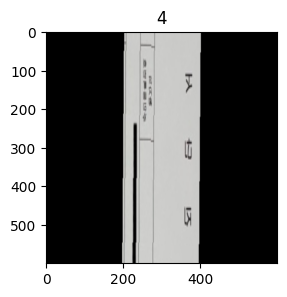

In [13]:
plt.figure(figsize=(3, 3))
plt.imshow(title_origin_dataset_3[100][0].permute(1, 2, 0))
plt.title(title_origin_dataset_3[100][1])
plt.show()

In [9]:
train_dataset = torch.utils.data.ConcatDataset([aug_dataset_1, aug_dataset_2, aug_dataset_3, 
                                                aug_dataset_4, aug_dataset_5, aug_dataset_6, 
                                                aug_dataset_7, aug_dataset_8, aug_dataset_9, 
                                                aug_dataset_10, aug_dataset_11, aug_dataset_12,
                                                aug_dataset_13, aug_dataset_14, aug_dataset_15,
                                                aug_dataset_16, aug_dataset_17, aug_dataset_18,
                                                aug_dataset_19, aug_dataset_20, aug_dataset_21,
                                                aug_dataset_22, aug_dataset_23, aug_dataset_24, aug_dataset_25,

                                                simple_aug_dataset_1, simple_aug_dataset_2, simple_aug_dataset_3,
                                                simple_aug_dataset_4,

                                                origin_dataset_1, origin_dataset_2,
                                                
                                                title_aug_dataset_1,
                                                
                                                title_origin_dataset_1])

In [10]:
len(train_dataset)

48670

# valid dataset

### train data 중 일부 사용

In [11]:
total_num = len(train_dataset)
train_num, valid_num = int(total_num*0.8), int(total_num*0.2)

train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [train_num, valid_num])

### v.1.3의 예측 결과 사용

In [64]:
valid_transforms = T.Compose([
    T.ToTensor(),
    T.Resize((600, 600))
])

valid_dataset = customdataset('/data/ephemeral/home/preds/v1_3_preds.csv', '/data/ephemeral/home/data/test/', transforms=valid_transforms) # valid dataset

In [65]:
len(train_dataset)

27030

In [66]:
len(valid_dataset)

3140

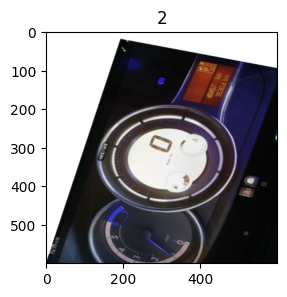

In [70]:
plt.figure(figsize=(3, 3))
plt.imshow(valid_dataset[0][0].permute(1, 2, 0))
plt.title(valid_dataset[0][1])
plt.show()

In [12]:
batch_size = 100

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True, num_workers=16)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size, shuffle=False, num_workers=16)

# 학습

### 학습전 모델 이름 바꿔주기!!

In [14]:
def training(model, train_dataloader, train_dataset, criterion, optimizer, epoch, num_epochs):
    model.train()
    train_loss = 0.0
    train_accuracy = 0

    tbar = tqdm(train_dataloader)
    for images, labels in tbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        max_prob, predicted = torch.max(outputs, 1)
        train_accuracy += (predicted == labels).sum().item()

        tbar.set_description(f'Epoch/Epochs [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}')

    train_loss = train_loss / len(train_dataloader)
    train_accuracy = train_accuracy / len(train_dataset)

    return model, train_loss, train_accuracy

def evalutaion(model, valid_dataloader, valid_accuracy, criterion, epoch, num_epochs):
    model.eval()
    valid_loss = 0.0
    valid_accuracy = 0

    with torch.no_grad():
        tbar = tqdm(valid_dataloader)
        for images, labels in tbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            valid_loss += loss.item()
            max_prob, predicted = torch.max(outputs, 1)
            valid_accuracy += (predicted == labels).sum().item()

            tbar.set_description(f'Epoch/Epochs [{epoch+1}/{num_epochs}], Valid Loss: {loss.item():.4f}')

    valid_loss = valid_loss / len(valid_dataloader)
    valid_accuracy = valid_accuracy / len(valid_dataset)

    return model, valid_loss, valid_accuracy

def training_loop(model, train_dataloader, train_dataset, valid_dataloader, valid_dataset, criterion, optimizer, num_epochs):
    best_valid_loss = float('inf')
    early_stop_cnt = 0
    valid_max_accuracy = -1

    for epoch in range(num_epochs):
        model, train_loss, train_accuracy = training(model, train_dataloader, train_dataset, criterion, optimizer, epoch, num_epochs)
        model, valid_loss, valid_accuracy = evalutaion(model, valid_dataloader, valid_dataset, criterion, epoch, num_epochs)

        #monitoring_values = {'Train Loss': train_loss, 'Valid Loss': valid_loss, 'Train Accuracy': train_accuracy, 'Valid Accuracy': valid_accuracy}
        #run.log(monitoring_values, step=epoch)

        if valid_accuracy > valid_max_accuracy:
            valid_max_accuracy = valid_accuracy

        if valid_loss < best_valid_loss:
            torch.save(model.state_dict(), f"/data/ephemeral/home/model/models/model_v3_4_best.pt")
            best_valid_loss = valid_loss
            early_stop_cnt = 0

        else :
            early_stop_cnt += 1

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f} Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}")

        if early_stop_cnt >= 5:
            torch.save(model.state_dict(), f"/data/ephemeral/home/model/models/model_v3_4_last.pt")
            print('Early Stopping')
            break

    return model

In [15]:
model = timm.create_model(
    'resnet34',
    pretrained=True,
    num_classes=17
).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [15]:
model = training_loop(model, train_dataloader, train_dataset, valid_dataloader, valid_dataset, criterion, optimizer, 100)

  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [1/100], Train Loss: 0.8699, Train Accuracy: 0.7065 Valid Loss: 0.6096, Valid Accuracy: 0.7882


  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [2/100], Train Loss: 0.3233, Train Accuracy: 0.8834 Valid Loss: 0.4994, Valid Accuracy: 0.8220


  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [3/100], Train Loss: 0.2294, Train Accuracy: 0.9174 Valid Loss: 0.4088, Valid Accuracy: 0.8552


  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [4/100], Train Loss: 0.1737, Train Accuracy: 0.9396 Valid Loss: 0.3657, Valid Accuracy: 0.8726


  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [5/100], Train Loss: 0.1486, Train Accuracy: 0.9467 Valid Loss: 0.3913, Valid Accuracy: 0.8675


  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [6/100], Train Loss: 0.1295, Train Accuracy: 0.9542 Valid Loss: 0.4252, Valid Accuracy: 0.8531


  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [7/100], Train Loss: 0.1055, Train Accuracy: 0.9629 Valid Loss: 0.3616, Valid Accuracy: 0.8772


  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [8/100], Train Loss: 0.0940, Train Accuracy: 0.9674 Valid Loss: 0.3039, Valid Accuracy: 0.8951


  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [9/100], Train Loss: 0.0891, Train Accuracy: 0.9682 Valid Loss: 0.2101, Valid Accuracy: 0.9291


  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [10/100], Train Loss: 0.0790, Train Accuracy: 0.9725 Valid Loss: 0.2467, Valid Accuracy: 0.9202


  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [11/100], Train Loss: 0.0741, Train Accuracy: 0.9737 Valid Loss: 0.5206, Valid Accuracy: 0.8236


  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [12/100], Train Loss: 0.0673, Train Accuracy: 0.9768 Valid Loss: 0.1973, Valid Accuracy: 0.9367


  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [13/100], Train Loss: 0.0656, Train Accuracy: 0.9774 Valid Loss: 0.3789, Valid Accuracy: 0.8912


  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [14/100], Train Loss: 0.0647, Train Accuracy: 0.9773 Valid Loss: 0.2273, Valid Accuracy: 0.9254


  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [15/100], Train Loss: 0.0671, Train Accuracy: 0.9761 Valid Loss: 0.2001, Valid Accuracy: 0.9300


  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [16/100], Train Loss: 0.0523, Train Accuracy: 0.9821 Valid Loss: 0.2093, Valid Accuracy: 0.9300


  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [17/100], Train Loss: 0.0550, Train Accuracy: 0.9815 Valid Loss: 0.4748, Valid Accuracy: 0.8363


  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [18/100], Train Loss: 0.0527, Train Accuracy: 0.9815 Valid Loss: 0.2631, Valid Accuracy: 0.9096


  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [19/100], Train Loss: 0.0536, Train Accuracy: 0.9810 Valid Loss: 0.2498, Valid Accuracy: 0.9168


  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [20/100], Train Loss: 0.0480, Train Accuracy: 0.9823 Valid Loss: 0.1662, Valid Accuracy: 0.9463


  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [21/100], Train Loss: 0.0424, Train Accuracy: 0.9859 Valid Loss: 0.3338, Valid Accuracy: 0.9086


  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [22/100], Train Loss: 0.0435, Train Accuracy: 0.9852 Valid Loss: 0.1598, Valid Accuracy: 0.9470


  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [23/100], Train Loss: 0.0376, Train Accuracy: 0.9863 Valid Loss: 0.0990, Valid Accuracy: 0.9658


  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [24/100], Train Loss: 0.0426, Train Accuracy: 0.9849 Valid Loss: 0.2013, Valid Accuracy: 0.9388


  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [25/100], Train Loss: 0.0414, Train Accuracy: 0.9862 Valid Loss: 0.0968, Valid Accuracy: 0.9667


  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [26/100], Train Loss: 0.0388, Train Accuracy: 0.9863 Valid Loss: 0.0921, Valid Accuracy: 0.9691


  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [27/100], Train Loss: 0.0389, Train Accuracy: 0.9858 Valid Loss: 0.1544, Valid Accuracy: 0.9478


  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [28/100], Train Loss: 0.0376, Train Accuracy: 0.9863 Valid Loss: 0.3643, Valid Accuracy: 0.9004


  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [29/100], Train Loss: 0.0304, Train Accuracy: 0.9895 Valid Loss: 0.1169, Valid Accuracy: 0.9605


  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [30/100], Train Loss: 0.0393, Train Accuracy: 0.9863 Valid Loss: 0.2860, Valid Accuracy: 0.9256


  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [31/100], Train Loss: 0.0328, Train Accuracy: 0.9888 Valid Loss: 0.2620, Valid Accuracy: 0.9291


  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [32/100], Train Loss: 0.0300, Train Accuracy: 0.9891 Valid Loss: 0.3785, Valid Accuracy: 0.8927


  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [33/100], Train Loss: 0.0333, Train Accuracy: 0.9886 Valid Loss: 0.0860, Valid Accuracy: 0.9720


  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [34/100], Train Loss: 0.0271, Train Accuracy: 0.9907 Valid Loss: 0.1703, Valid Accuracy: 0.9499


  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [35/100], Train Loss: 0.0282, Train Accuracy: 0.9902 Valid Loss: 0.0766, Valid Accuracy: 0.9743


  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [36/100], Train Loss: 0.0326, Train Accuracy: 0.9890 Valid Loss: 0.1844, Valid Accuracy: 0.9463


  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [37/100], Train Loss: 0.0266, Train Accuracy: 0.9906 Valid Loss: 0.5324, Valid Accuracy: 0.8684


  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [38/100], Train Loss: 0.0257, Train Accuracy: 0.9914 Valid Loss: 0.2574, Valid Accuracy: 0.9312


  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [39/100], Train Loss: 0.0286, Train Accuracy: 0.9902 Valid Loss: 0.5998, Valid Accuracy: 0.8749


  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [40/100], Train Loss: 0.0263, Train Accuracy: 0.9913 Valid Loss: 0.2093, Valid Accuracy: 0.9437


  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [41/100], Train Loss: 0.0263, Train Accuracy: 0.9915 Valid Loss: 0.0880, Valid Accuracy: 0.9711


  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [42/100], Train Loss: 0.0262, Train Accuracy: 0.9909 Valid Loss: 0.2692, Valid Accuracy: 0.9273


  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [43/100], Train Loss: 0.0294, Train Accuracy: 0.9899 Valid Loss: 0.0775, Valid Accuracy: 0.9770


  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [44/100], Train Loss: 0.0237, Train Accuracy: 0.9919 Valid Loss: 0.0939, Valid Accuracy: 0.9708


  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [45/100], Train Loss: 0.0201, Train Accuracy: 0.9932 Valid Loss: 0.5039, Valid Accuracy: 0.8626
Early Stopping


# Test

In [ ]:
model.eval()
test_loss = 0.0
test_accuracy = 0

all_preds = []

with torch.no_grad():
    tbar = tqdm(test_dataloader)
    for images, labels in tbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        max_prob, predicted = torch.max(outputs, 1)
        test_accuracy += (predicted == labels).sum().item()

        all_preds.extend(predicted)

test_loss = test_loss / len(test_dataloader)
test_accuracy = test_accuracy / len(test_dataset)

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

NameError: name 'test_dataloader' is not defined

In [ ]:
plt.figure(figsize=(20, 20))

for i in range(20, 40):
    ax = plt.subplot(4, 5, (i%20)+1)

    plt.imshow(test_dataset[i][0].permute(1, 2, 0))
    plt.title(f'real: {test_dataset[i][1]}\npred: {all_preds[i].cpu()}')

# Submission

In [5]:
model = timm.create_model(
    'resnet34',
    pretrained=True,
    num_classes=17
).to(device)
model.load_state_dict(torch.load('/data/ephemeral/home/model/models/model_v3_4_last.pt'))

criterion = torch.nn.CrossEntropyLoss()

In [6]:
class sub_customdataset(torch.utils.data.Dataset):
    def __init__(self, csv, path, transforms):
        super().__init__()
        self.df = pd.read_csv(csv).values
        self.path = path
        self.transforms = transforms

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        name, target = self.df[idx]
        img = np.array(Image.open(os.path.join(self.path, name)))
        img = self.transforms(img)
    
        return img, target

In [7]:
transforms = T.Compose([
    T.ToTensor(),
    T.Resize((600, 600))
])

sub_dataset = sub_customdataset('/data/ephemeral/home/data/sample_submission.csv', '/data/ephemeral/home/data/test/', transforms=transforms)

In [8]:
batch_size = 100

sub_dataloader = torch.utils.data.DataLoader(sub_dataset, batch_size=batch_size, shuffle=False, num_workers=16)

In [20]:
model.eval()

all_preds = []
all_labels = []
all_images = []

with torch.no_grad():
    tbar = tqdm(sub_dataloader)
    for images, labels in tbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        max_prob, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted)
        all_labels.extend(labels)
        all_images.extend(images)


  0%|          | 0/32 [00:00<?, ?it/s]

In [21]:
all_preds

[tensor(2, device='cuda:0'),
 tensor(10, device='cuda:0'),
 tensor(5, device='cuda:0'),
 tensor(4, device='cuda:0'),
 tensor(2, device='cuda:0'),
 tensor(15, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(8, device='cuda:0'),
 tensor(15, device='cuda:0'),
 tensor(11, device='cuda:0'),
 tensor(5, device='cuda:0'),
 tensor(4, device='cuda:0'),
 tensor(16, device='cuda:0'),
 tensor(9, device='cuda:0'),
 tensor(3, device='cuda:0'),
 tensor(4, device='cuda:0'),
 tensor(4, device='cuda:0'),
 tensor(5, device='cuda:0'),
 tensor(13, device='cuda:0'),
 tensor(10, device='cuda:0'),
 tensor(12, device='cuda:0'),
 tensor(12, device='cuda:0'),
 tensor(1, device='cuda:0'),
 tensor(15, device='cuda:0'),
 tensor(3, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(14, device='cuda:0'),
 tensor(13, device='cuda:0'),
 tensor(13, device='cuda:0'),
 tensor(6, device='cuda:0'),
 tensor(3, device='cuda:0'),
 tensor(13, device='cuda:0'),
 tensor(13, device='cuda:0'),
 tensor(2, device='cuda:0'),

In [22]:
sub_df = pd.read_csv('/data/ephemeral/home/data/sample_submission.csv')
sub_df

,ID,target
0,0008fdb22ddce0ce.jpg,0
1,00091bffdffd83de.jpg,0
2,00396fbc1f6cc21d.jpg,0
3,00471f8038d9c4b6.jpg,0
4,00901f504008d884.jpg,0
...,...,...
3135,ffb4b6f619fb60ea.jpg,0
3136,ffb54299b1ad4159.jpg,0
3137,ffc2c91dff8cf2c0.jpg,0
3138,ffc4e330a5353a2a.jpg,0


In [23]:
for i in range(3140):
    sub_df.iloc[i, 1] = int(all_preds[i].cpu())

In [24]:
sub_df[sub_df['target']==6].head(10)

,ID,target
29,02ac23941313841b.jpg,6
64,06a484eb2afab068.jpg,6
69,0716d938d4ee1685.jpg,6
107,0a0302cbe2dcdd40.jpg,6
110,0a46d57f7a0b0407.jpg,6
125,0b49d225b1648438.jpg,6
129,0b9483ad39e27019.jpg,6
137,0c62c4ec8d5042a7.jpg,6
150,0dca6453aea515b9.jpg,6
158,0e82d902e8be0e62.jpg,6


In [25]:
sub_df.to_csv('/data/ephemeral/home/preds/v3_4_last_preds.csv', index=False)